In [34]:
import pandas as pd
import numpy as np
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
brown_ic = wordnet_ic.ic('ic-brown.dat')
import matplotlib as plt
import os
from collections import Counter
from scipy.interpolate import interp1d
from nltk.corpus import verbnet
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import classification_report
tqdm.pandas()
scale_converter = interp1d([0,6],[0,10])

# WordNet demo

Choose some words:

In [2]:
word1 = "turn"
word2 = "twist"
word3 = "jump"

Synsets:

In [3]:
print("Synsets for", word1)
print(wn.synsets(word1))
print()
print("Synsets for",word1,"filtered just to verb POS")
print(wn.synsets(word1, pos = wn.VERB))

Synsets for turn
[Synset('bend.n.01'), Synset('turn.n.02'), Synset('turn.n.03'), Synset('turn.n.04'), Synset('turning.n.04'), Synset('turn.n.06'), Synset('twist.n.13'), Synset('go.n.01'), Synset('turn.n.09'), Synset('act.n.04'), Synset('turn.n.11'), Synset('turn.n.12'), Synset('turn.v.01'), Synset('change_state.v.01'), Synset('become.v.02'), Synset('turn.v.04'), Synset('change_by_reversal.v.01'), Synset('turn.v.06'), Synset('turn.v.07'), Synset('turn.v.08'), Synset('turn.v.09'), Synset('turn.v.10'), Synset('turn.v.11'), Synset('plow.v.01'), Synset('turn.v.13'), Synset('turn.v.14'), Synset('twist.v.10'), Synset('turn.v.16'), Synset('turn.v.17'), Synset('turn.v.18'), Synset('turn.v.19'), Synset('turn.v.20'), Synset('flex.v.05'), Synset('turn.v.22'), Synset('turn.v.23'), Synset('call_on.v.01'), Synset('sour.v.01'), Synset('turn.v.26')]

Synsets for turn filtered just to verb POS
[Synset('turn.v.01'), Synset('change_state.v.01'), Synset('become.v.02'), Synset('turn.v.04'), Synset('change_b

Just for now, selecting the first synset

In [4]:
w1_syn = wn.synsets(word1, pos = wn.VERB)[0]
w2_syn = wn.synsets(word2, pos = wn.VERB)[0]
w3_syn = wn.synsets(word3, pos = wn.VERB)[0]

# Verb frames:

For the synsets' lemma, it has a specific amount of verb frames. It generally seems to be the same amount per synset for each lemma.

In [5]:
for lemma in w1_syn.lemmas():
    print(lemma, lemma.frame_ids(), len(lemma.frame_ids()))
    print(" | ".join(lemma.frame_strings()))
print("------------------------------")

for lemma in w2_syn.lemmas():
    print(lemma, lemma.frame_ids(), len(lemma.frame_ids()))
    print(" | ".join(lemma.frame_strings()))
print("------------------------------")

for lemma in w3_syn.lemmas():
    print(lemma, lemma.frame_ids(), len(lemma.frame_ids()))
    print(" | ".join(lemma.frame_strings()))
print("------------------------------")

Lemma('turn.v.01.turn') [1, 2, 4] 3
Something turn | Somebody turn | Something is turning PP
------------------------------
Lemma('writhe.v.01.writhe') [1, 2] 2
Something writhe | Somebody writhe
Lemma('writhe.v.01.wrestle') [1, 2] 2
Something wrestle | Somebody wrestle
Lemma('writhe.v.01.wriggle') [1, 2] 2
Something wriggle | Somebody wriggle
Lemma('writhe.v.01.worm') [1, 2] 2
Something worm | Somebody worm
Lemma('writhe.v.01.squirm') [1, 2] 2
Something squirm | Somebody squirm
Lemma('writhe.v.01.twist') [1, 2] 2
Something twist | Somebody twist
------------------------------
Lemma('jump.v.01.jump') [1, 2, 22] 3
Something jump | Somebody jump | Somebody jump PP
Lemma('jump.v.01.leap') [1, 2, 22] 3
Something leap | Somebody leap | Somebody leap PP
Lemma('jump.v.01.bound') [1, 2, 22] 3
Something bound | Somebody bound | Somebody bound PP
Lemma('jump.v.01.spring') [1, 2, 22] 3
Something spring | Somebody spring | Somebody spring PP
------------------------------


# Multiple similarity metrics: 

Path similarity

Leacock-Chodorow Similarity

Wu-Palmer similarity

Resnik similarity

Jiang-Conrath similarity

Lin Similarity

In [6]:
print("Path similarity:", w1_syn.path_similarity(w2_syn))

print("Lch similarity:",w1_syn.lch_similarity(w2_syn))

print("Wup similarity:",w1_syn.wup_similarity(w2_syn))

print("Res similarity:",w1_syn.res_similarity(w2_syn, brown_ic))

print("JCN similarity:",w1_syn.jcn_similarity(w2_syn, brown_ic))

print("Lin similarity:",w1_syn.lin_similarity(w2_syn, brown_ic))

Path similarity: 0.3333333333333333
Lch similarity: 2.159484249353372
Wup similarity: 0.3333333333333333
Res similarity: 4.692755582239643
JCN similarity: 0.12831564565996478
Lin similarity: 0.546342873109817


# VerbNet:

http://verbs.colorado.edu/~kipper/Papers/dissertation.pdf

http://verbs.colorado.edu/verb-index/VerbNet_Guidelines.pdf

In [7]:
a = verbnet.classids(lemma = "give")
print(a)

print("lemmas",verbnet.lemmas(a[0]))

print("vnclass",verbnet.vnclass(a[0]))

print("Sub-classes", verbnet.subclasses(verbnet.vnclass(a[0])))

['give-13.1-1']
lemmas ['give', 'hock', 'rent', 'sell', 'lease', 'pawn']
vnclass <Element 'VNSUBCLASS' at 0x7f23f3046a40>
Sub-classes []


In [8]:
def get_classid(verb):
    # print(verb)
    classid = verbnet.classids(lemma = verb)
    # print(classid)
    return classid
    
def get_lemmas(verb):
    classid = get_classid(verb)
    if len(classid) > 0:
        lemmas = verbnet.lemmas(classid[0])
        return lemmas
    else:
        return "-1"

def get_frames(verb):
    classid = get_classid(verb)
    if len(classid) > 0:
        frames = []
        for item in verbnet.frames(classid[0]):
            # print(item)
            frames.append(item["description"]["primary"])
        return frames
    else:
        return ["-1"]

def get_unique_frames(classid):
    frames = []
    for item in verbnet.frames(classid[0]):
        # print(item)
        frames.append(item["description"]["primary"])
    return pd.unique(frames)

In [9]:
# step1 = get_classid("catch")
# print(step1)

# step2a = get_lemmas(step1)
# print(step2a)

# step2b = get_frames(step1)
# print(step2b)


In [10]:
#word: "give"
frames = verbnet.frames(verbnet.vnclass(a[0]))
for item in frames:
    for key in item.keys():
        print(key,":", item[key])
        print()
    print()
    print("--------------------------")

example : He leased the car for $200 a week.

description : {'primary': 'NP-PP', 'secondary': 'Asset-PP'}

syntax : [{'pos_tag': 'NP', 'modifiers': {'value': 'Agent', 'selrestrs': [], 'synrestrs': []}}, {'pos_tag': 'VERB', 'modifiers': {'value': '', 'selrestrs': [], 'synrestrs': []}}, {'pos_tag': 'NP', 'modifiers': {'value': 'Theme', 'selrestrs': [], 'synrestrs': []}}, {'pos_tag': 'PREP', 'modifiers': {'value': 'for at', 'selrestrs': [], 'synrestrs': []}}, {'pos_tag': 'NP', 'modifiers': {'value': 'Asset', 'selrestrs': [], 'synrestrs': []}}]

semantics : [{'predicate_value': 'has_possession', 'arguments': [{'type': 'Event', 'value': 'start(E)'}, {'type': 'ThemRole', 'value': 'Agent'}, {'type': 'ThemRole', 'value': 'Theme'}]}, {'predicate_value': 'has_possession', 'arguments': [{'type': 'Event', 'value': 'end(E)'}, {'type': 'ThemRole', 'value': '?Recipient'}, {'type': 'ThemRole', 'value': 'Theme'}]}, {'predicate_value': 'has_possession', 'arguments': [{'type': 'Event', 'value': 'start(E)

In [11]:
print(word1,":")
verbnet.classids(lemma = word1)

turn :


['convert-26.6.2',
 'crane-40.3.2',
 'hurt-40.8.3-1-1',
 'meander-47.7',
 'roll-51.3.1',
 'turn-26.6.1-1']

*Verbs that participate in this alternation include scatter, pump, hang, drizzle, and cram, all of which are verbs that semantically involve a type of placement or covering. Because of their shared syntactic behaviors, these verbs are grouped together in the Spray-‐9.7 class.*

Share syntactic behaviors -> grouped together in classes -> check shared classes?

In [12]:
print(word1,":", verbnet.classids(lemma = word1))
print(word2,":", verbnet.classids(lemma = word2))
print(word3,":", verbnet.classids(lemma = word3))

turn : ['convert-26.6.2', 'crane-40.3.2', 'hurt-40.8.3-1-1', 'meander-47.7', 'roll-51.3.1', 'turn-26.6.1-1']
twist : ['coil-9.6-1', 'hurt-40.8.3-1-1', 'knead-26.5', 'meander-47.7', 'roll-51.3.1']
jump : ['calibratable_cos-45.6-1', 'run-51.3.2']


# SimVerb:

In [13]:
simverb = pd.read_csv("../data/SimVerb-3500.txt",sep='\t', header = None)

simverb.columns = ["word1","word2","pos","sv_score",'relation']

print(simverb)

            word1     word2 pos  sv_score        relation
0            take    remove   V      6.81        SYNONYMS
1            walk     trail   V      4.81      COHYPONYMS
2            feed    starve   V      1.49        ANTONYMS
3           shine    polish   V      7.80        SYNONYMS
4       calculate       add   V      5.98  HYPER/HYPONYMS
...           ...       ...  ..       ...             ...
3495       impose     cheat   V      1.16            NONE
3496        rebel   protest   V      7.64  HYPER/HYPONYMS
3497  collaborate  conspire   V      4.23            NONE
3498     conspire   protest   V      1.83            NONE
3499      protest   release   V      1.16            NONE

[3500 rows x 5 columns]


In [14]:
simverb_full_ratings = pd.read_csv("../data/SimVerb-3520-annotator-ratings.csv", header = None)
# simverb.columns = ["word1","word2","pos","sv_score",'relation']
indexes = range(0,702, 1)
cols = ["r"+ str(rater) for rater in indexes]
colsets = ["r"+ str(rater) for rater in indexes]
cols.insert(0, "word2")
cols.insert(0, "word1")
simverb_full_ratings.columns = cols
print(simverb_full_ratings)

         word1     word2  r0  r1  r2  r3  r4  r5  r6  r7  ...  r692  r693  \
0       obtain  exchange   2   1   0   0   0   2   1   4  ...     2     3   
1         draw     paint   3   4   2   4   5   3   2   4  ...     5     5   
2       choose      pick  -1  -1  -1  -1  -1  -1  -1  -1  ...    -1    -1   
3        seize   control  -1  -1  -1  -1  -1  -1  -1  -1  ...    -1    -1   
4     disprove      deny  -1  -1  -1  -1  -1  -1  -1  -1  ...    -1    -1   
...        ...       ...  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   
3515      save   reserve  -1  -1  -1  -1  -1  -1  -1  -1  ...    -1    -1   
3516   clarify    repeat  -1  -1  -1  -1  -1  -1  -1  -1  ...    -1    -1   
3517      yell      talk  -1  -1  -1  -1  -1  -1  -1  -1  ...    -1    -1   
3518     grant      give  -1  -1  -1  -1  -1  -1  -1  -1  ...    -1    -1   
3519      swim   flutter  -1  -1  -1  -1  -1  -1  -1  -1  ...    -1    -1   

      r694  r695  r696  r697  r698  r699  r700  r701  
0        0     2    

In [15]:
simverb_ratings = pd.read_csv("../data/SimVerb-3500-ratings.csv")

# print(simverb_ratings)

simverb_ratings["mean_rating"] = scale_converter(simverb_ratings[['r1','r2','r3','r4','r5','r6','r7','r8','r9','r10']].mean(axis = 1))
simverb_ratings["sd_rating"] = simverb_ratings[['r1','r2','r3','r4','r5','r6','r7','r8','r9','r10']].std(axis = 1)

## Background: 
- Meaning as inherent in word relations, meaning as derived from statistical regularities -> distributional semantics theory of word meaning


- Verbs and nouns are conceptually different, which may be reflected in age of acquisition for English speaking babies 
- Noun bias (see Ch11 from https://langcog.github.io/wordbank-book/categories-syntactic.html)
- Nouns seem to be more "indexical" in nature, with a given label (usually) mapping directly to a object, or more concrete aspect, while verbs are more relational (Gentner, 1982)
- Other considerations: syntactic position, morphology


- This difference is also reflected in distributional semantics models
- Distributional semantics models as harnessing the co-occurrence statistics to capture word meaning
- Variety of models perform well on different tasks, however, recently developed gold standards (simlex, simverb) have shown that their performance greatly differs based on part of speech


- What differentiates these two POS in their representation? 

## Research question:
- What is the relationship between syntax and semantics for verb understanding? 
- How do syntax and semantics interact regarding verb representation?
- How do these models reflect our own linguistic processing of verbs?

General question: See above ^

Research question: Does syntactic and semantic info impact people's performance on human judgement of similarity?

-> show specifically these different types of information --> control condition (has syntax but not informative about their meaning representation)

-> inter annotater agreement

Corpus data -> frequencies of ()

Google ngrams -> syntactic version (syntgram), checking syntactic frame (counts)

## Implementation / approach:
- Use WordNet and VerbNet as *what* -> syntactic reference point?
- POS disambiguation: number of different potential parts of speech for a given word -> entropy of potential POS?
- Sense disambiguation: 1) number of different senses, 2) average similarity to other senses
- *VerbNet* something with subcat bias?

### Other thoughts:
- Lemmas and amount of verb frames?
- Entailment environment

#### Out of the scope of this study:
- Comparison between languages with and without noun bias

In [16]:
# Cases when word not in WN?

def potential_pos(word):
    pos = []
    for sense in wn.synsets(word):
        pos.append(sense.pos())
    return Counter(pos)
        
    
def num_v_senses(word):
#     print(wn.synsets(word, pos = wn.VERB))
    num_senses = len(wn.synsets(word, pos = wn.VERB))
#     print(num_senses)
    return num_senses

In [17]:
# simverb["w1_pos"] = simverb['word1'].progress_apply(potential_pos)
simverb["w1_num_v_senses"] = simverb['word1'].progress_apply(num_v_senses)
# simverb["w2_pos"] = simverb['word2'].progress_apply(potential_pos)
simverb["w2_num_v_senses"] = simverb['word2'].progress_apply(num_v_senses)

100%|██████████| 3500/3500 [00:00<00:00, 118657.46it/s]


In [18]:
# simverb["w1_lemmas"] = simverb["word1"].progress_apply(get_lemmas)
# simverb["w2_lemmas"] = simverb["word2"].progress_apply(get_lemmas)
simverb["w1_frames"] = simverb["word1"].progress_apply(get_frames)
simverb["w2_frames"] = simverb["word2"].progress_apply(get_frames)

100%|██████████| 3500/3500 [00:01<00:00, 1925.81it/s]


In [19]:
sv_ratings = simverb_ratings[["word1", "word2","mean_rating","sd_rating"]]

# print(simverb_ratings)

sv_set = pd.merge(simverb, sv_ratings, how = "left", on = ["word1", "word2"])

In [20]:
print(sv_set)

            word1     word2 pos  sv_score        relation  w1_num_v_senses  \
0            take    remove   V      6.81        SYNONYMS               42   
1            walk     trail   V      4.81      COHYPONYMS               10   
2            feed    starve   V      1.49        ANTONYMS               12   
3           shine    polish   V      7.80        SYNONYMS               10   
4       calculate       add   V      5.98  HYPER/HYPONYMS                6   
...           ...       ...  ..       ...             ...              ...   
3495       impose     cheat   V      1.16            NONE                3   
3496        rebel   protest   V      7.64  HYPER/HYPONYMS                2   
3497  collaborate  conspire   V      4.23            NONE                2   
3498     conspire   protest   V      1.83            NONE                2   
3499      protest   release   V      1.16            NONE                3   

      w2_num_v_senses                                          

In [27]:
data_frames = np.unique(sv_set[["w1_frames","w2_frames"]].values)

unique_frames = []

for item in data_frames:
    for frame in item:
        unique_frames.append(frame)

unique_frames = np.unique(unique_frames)
print(unique_frames)
print(len(unique_frames))

# One-hot encoding? Index coding? Number of syntax frames?


sv_set["shared_frames"] = sv_set.apply(lambda row: len(list(set(row.w1_frames) & set(row.w2_frames))), axis = 1)


['(SUBCAT ADL)' '(SUBCAT MP)' '-1' 'ADJP' 'ADJP-PP' 'ADVP-PRED'
 'Attribute Object Possessor-Attribute Factoring Alternation'
 'Basic Intransitive' 'Basic Transitive' 'Benefactive Alternation'
 'Characteristic Property of Instrument' 'Conative' 'Dative' 'FOR-TO-INF'
 'HOW-S' 'HOW-TO-INF' 'ING-AC' 'ING-NP-OMIT' 'ING-SC/BE-ING'
 'ING-SC/BE-ING-SC' 'Infinitival Copular Clause'
 'Instrument Subject Alternation' 'Intransitive'
 'Location Subject Alternation' 'Locative Inversion'
 'Locative Preposition Drop' 'Locatum Subject Alternation'
 'Material/Product Alternation Transitive' 'Middle Construction' 'NP'
 'NP-ADJP' 'NP-ADJP-PP' 'NP-ADJP-PRED' 'NP-ADVP-PRED' 'NP-HOW-S'
 'NP-HOW-TO-INF' 'NP-ING-SC' 'NP-NP' 'NP-NP-PP' 'NP-NP-PRED' 'NP-P-ING'
 'NP-P-ING-AC' 'NP-P-ING-OC' 'NP-P-ING-SC' 'NP-PP' 'NP-PP-PP' 'NP-QUOT'
 'NP-S' 'NP-TO-INF-OC' 'NP-TOBE' 'NP-VEN-NP-OMIT' 'NP-WH-S' 'NP-WH-TO-INF'
 'NP-WHAT-S' 'NP-WHAT-TO-INF' 'P-ING-SC' 'P-NP-ING' 'P-NP-TO-INF'
 'P-POSSING' 'P-WH-S' 'P-WH-TO-INF' 'P-WHA

In [22]:
sv_set["w1_frame_count"] = sv_set["w1_frames"].apply(len)
sv_set["w2_frame_count"] = sv_set["w2_frames"].apply(len)
relations = np.sort(pd.unique(sv_set["relation"]))
keys = list(range(0, len(relations)))
relation_dict = {relations[i]: keys[i] for i in range(len(relations))}
sv_set["relation_index"] = sv_set["relation"].map(relation_dict)
print(sv_set)

            word1     word2 pos  sv_score        relation  w1_num_v_senses  \
0            take    remove   V      6.81        SYNONYMS               42   
1            walk     trail   V      4.81      COHYPONYMS               10   
2            feed    starve   V      1.49        ANTONYMS               12   
3           shine    polish   V      7.80        SYNONYMS               10   
4       calculate       add   V      5.98  HYPER/HYPONYMS                6   
...           ...       ...  ..       ...             ...              ...   
3495       impose     cheat   V      1.16            NONE                3   
3496        rebel   protest   V      7.64  HYPER/HYPONYMS                2   
3497  collaborate  conspire   V      4.23            NONE                2   
3498     conspire   protest   V      1.83            NONE                2   
3499      protest   release   V      1.16            NONE                3   

      w2_num_v_senses                                          

In [30]:
sv_set.to_csv("../data_output/simverb_processed.csv", index = False)

In [31]:
sv_set.describe()

,sv_score,w1_num_v_senses,w2_num_v_senses,mean_rating,sd_rating,w1_frame_count,w2_frame_count,relation_index,shared_frames
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,4.291554,7.957143,8.180286,4.311095,1.330124,4.035429,4.063714,2.655143,1.044286
std,2.652621,8.775755,9.072778,2.661175,0.511671,3.537074,3.561038,0.836567,1.667240
min,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.830000,3.000000,3.000000,1.833333,0.971825,1.000000,1.000000,2.000000,0.000000
50%,4.320000,5.000000,5.000000,4.333333,1.370320,3.000000,3.000000,3.000000,0.000000
75%,6.340000,10.000000,10.000000,6.333333,1.712698,5.000000,5.000000,3.000000,2.000000
max,9.960000,59.000000,59.000000,10.000000,2.838231,26.000000,26.000000,4.000000,25.000000


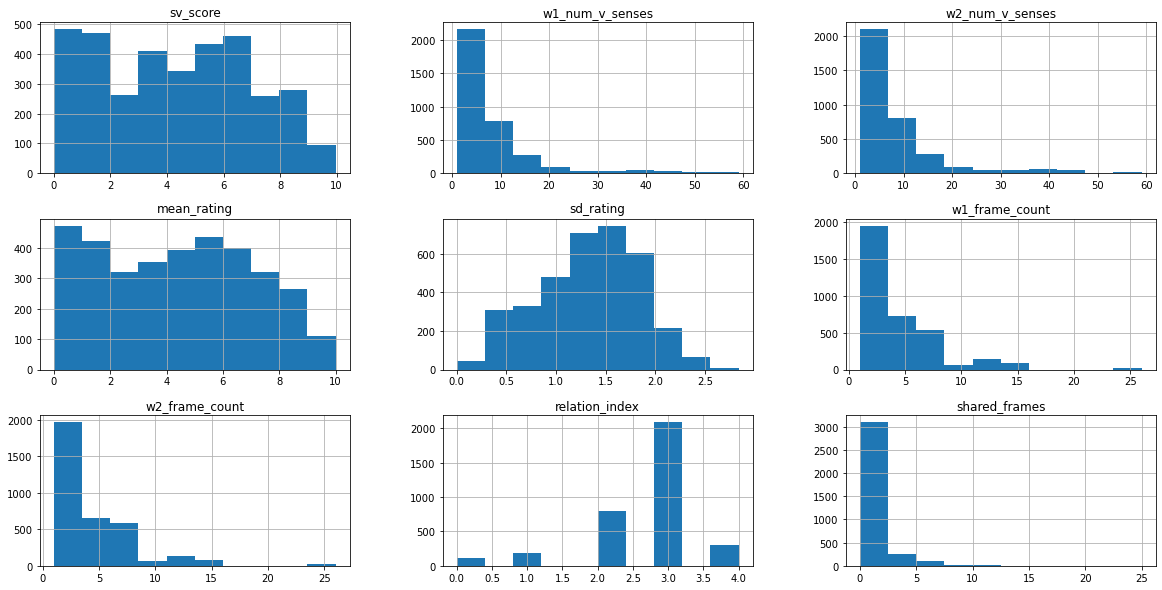

In [35]:
sv_set.hist(figsize=(20,10));

In [28]:
inputs = sv_set[["relation_index","w1_frame_count","w2_frame_count","w1_num_v_senses","w2_num_v_senses", "shared_frames"]]

targets = sv_set[["sd_rating"]]

mse_full = []

for i in range(0,50):

    (train_inputs, test_inputs, train_targets, test_targets) = train_test_split(inputs.to_numpy(), targets.to_numpy(), test_size=0.33)

    reg = LinearRegression().fit(train_inputs, train_targets)

    predicted_targets = reg.predict(test_inputs)

    mse_full.append(mean_squared_error(test_targets, predicted_targets))

###########################################################################################

inputs = sv_set[["w1_frame_count","w2_frame_count","w1_num_v_senses","w2_num_v_senses", "shared_frames"]]

targets = sv_set[["sd_rating"]]

mse_frames_senses = []

for i in range(0,50):

    (train_inputs, test_inputs, train_targets, test_targets) = train_test_split(inputs.to_numpy(), targets.to_numpy(), test_size=0.33)

    reg = LinearRegression().fit(train_inputs, train_targets)

    predicted_targets = reg.predict(test_inputs)
    
    mse_frames_senses.append(mean_squared_error(test_targets, predicted_targets))

########################################################################################

inputs = sv_set[["w1_num_v_senses","w2_num_v_senses"]]

targets = sv_set[["sd_rating"]]

mse_senses = []

for i in range(0,50):

    (train_inputs, test_inputs, train_targets, test_targets) = train_test_split(inputs.to_numpy(), targets.to_numpy(), test_size=0.33)

    reg = LinearRegression().fit(train_inputs, train_targets)

    predicted_targets = reg.predict(test_inputs)

    mse_senses.append(mean_squared_error(test_targets, predicted_targets))


########################################################################################

inputs = sv_set[["w1_frame_count","w2_frame_count", "shared_frames"]]

targets = sv_set[["sd_rating"]]

mse_frames = []

for i in range(0,50):

    (train_inputs, test_inputs, train_targets, test_targets) = train_test_split(inputs.to_numpy(), targets.to_numpy(), test_size=0.33)

    reg = LinearRegression().fit(train_inputs, train_targets)

    predicted_targets = reg.predict(test_inputs)

    mse_frames.append(mean_squared_error(test_targets, predicted_targets))

results_df = pd.DataFrame({"Full predictors": [np.mean(mse_full)], "Senses and Frames": [np.mean(mse_frames_senses)], 'Senses': [np.mean(mse_senses)], 'Frames': [np.mean(mse_frames)]})

print(results_df)


   Full predictors  Senses and Frames   Senses    Frames
0         0.262842           0.264383  0.26186  0.260545


In [70]:
# Train memory-based learner?

inputs = sv_set[["relation_index","w1_frame_count","w2_frame_count","w1_num_v_senses","w2_num_v_senses"]]

targets = sv_set[["sd_rating"]]

(train_inputs, test_inputs, train_targets, test_targets) = train_test_split(inputs.to_numpy(), targets.to_numpy(), test_size=0.33)

svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)

svr_rbf_fitted = svr_rbf.fit(train_inputs, train_targets.ravel())

predicted_targets = svr_rbf_fitted.predict(test_inputs)
print(mean_squared_error(predicted_targets, test_targets.ravel()))

# parameters = {"n_neighbors": [3,5,7,9],
#               "weights": ["uniform", "distance"],
#               "algorithm": ["auto","ball_tree","kd_tree", "brute"],
#               "metric": ["euclidean","manhattan","minkowski"]}


# knclf = KNeighborsClassifier()

# gridsearch = GridSearchCV(knclf,
#                           parameters,
#                           cv = 5)

# # print(test_targets.shape)

# knclf_fitted = gridsearch.fit(train_inputs, train_targets.ravel())

# predicted_targets = knclf_fitted.predict(test_inputs)
# print(classification_report(test_targets, predicted_targets))


0.5549019123591784


In [ ]:
# Inter-annotator agreement

# Todo:
Checking inter-annotater agreement, seeing how added context impacts the inter-annotater agreement.

Syntgram / triarcs -> check Rachel's grant (3.1.1)
- Syntactic frames of the different words
- Overlap measure -> shared frames, bias as majority frame -> more semantically related to other verbs of this type with same bias